In [3]:
import numpy as np
import mne
import mne_connectivity
from glob import glob
import pandas as pd
import pylab as plt
from copy import copy

# For parallel processing
import multiprocessing as mp
n_cpus = mp.cpu_count()

# For custom codebase
import sys
sys.path.insert(0, 'C:\\Users\\esolo\\Documents\\Python Scripts\\lib')

Idea is to compute functional connectivity (5-13 Hz) on proxy for "resting state" data -- the latter ~1 second of the sham intervals. Then correlate with TMS-related power changes. 

In [2]:
# Set parameters
subject = '593'
source_data = './multitaper_power/multitaper_power_0.05_0.55_3-8Hz.pkl'
subroot = 'D:/'+subject+'/'
target = 'L_DLPFC'

# Load the data and exclude bad electrodes
df = pd.read_pickle(source_data) 
df = df[(df['saturated']==False) & (df['noisy']==False) & (df['Seizure_Exclude']!=1)]
df_sub = copy(df[(df['subject']==subject) & (df['target'].str.contains(target))])

In [3]:
from codebase import subject_tfr

# Load the sham data for an example subject
mytfr = subject_tfr()
mytfr.load_data_epo(subject, target)

# Compute spectral connectivity
fc = mne_connectivity.spectral_connectivity_epochs(mytfr.epochs['sham'], method='coh', 
                                                   mode='multitaper', fmin=5, fmax=13, 
                                                  tmin=0.95, tmax=1.95, mt_bandwidth=4,
                                                  n_jobs=n_cpus, verbose=False)

Reading D:\593\complete_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 11 columns
250 matching events found
No baseline correction applied
0 projection items activated


In [4]:
# Construct adjacency matrix
adj = fc.get_data(output='dense')
adj = np.mean(adj, 2)  # average over frequencies
adj = adj+adj.T  # transpose and symmetrize

<Figure size 640x480 with 0 Axes>

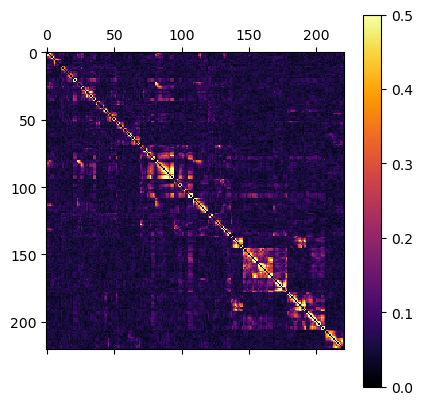

In [5]:
plt.figure()
plt.matshow(adj, cmap='inferno', vmin=0, vmax=0.5)
plt.colorbar()
#plt.savefig('./multitaper_epo_plots/593_adjacency.pdf')

In [6]:
from scipy.special import logit  # need to logit-transform coherence values

# Identify stimulated contact (either known or grab nearest electrode to the stimulation coordinates)
target_contact = int(mytfr.epochs.metadata['target_contact'].iloc[0])

# Find vector of coherences from target contact and get distances to target
node_names = pd.DataFrame(fc.names, columns=['name'])
idxs = list(node_names[node_names['name'].str.contains('LFPx'+str(target_contact))].index)
ephys_conn = logit(np.mean(adj[idxs, :], 0))  # average across all bipolar pairs containing the targeted contact
dists = np.array(df_sub['target_distance'])

# Get TMS-related powers
Ts = np.array(df_sub['T'])

# Some bad channels were statistically dropped from the powers array, so drop those from the
# adjacency matrix, too
ephys_conn_clean = []
for c in df_sub['channel_name']:
    ephys_idx = node_names[node_names['name']==c].index[0]
    ephys_conn_clean.append(ephys_conn[ephys_idx])
ephys_conn_clean = np.array(ephys_conn_clean)

# Finally, remove Infs or NaNs from both vectors
Ts_ = Ts[(np.isfinite(Ts)) & (np.isfinite(ephys_conn_clean)) & (Ts>-10)]
ephys_conn_clean_ = ephys_conn_clean[(np.isfinite(Ts)) & (np.isfinite(ephys_conn_clean)) & (Ts>-10)]
dists_clean = dists[(np.isfinite(Ts)) & (np.isfinite(ephys_conn_clean)) & (Ts>-10)]

# Get the distance-predicted powers
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(dists_clean.reshape(-1, 1), Ts_)
Ts_predict = model.predict(dists_clean.reshape(-1, 1))

# Residualize the powers
Ts_resid = Ts_-Ts_predict

<BarContainer object of 172 artists>

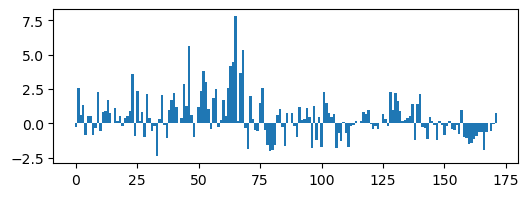

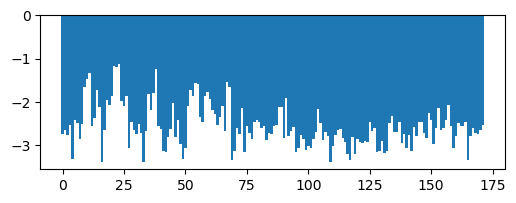

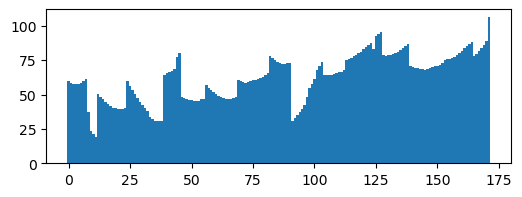

In [7]:
plt.figure(figsize=(6, 2)); 
plt.bar(np.arange(len(Ts_)), Ts_, width=1)
#plt.savefig('./multitaper_epo_plots/593_powers_bar.pdf')

plt.figure(figsize=(6, 2)); 
plt.bar(np.arange(len(Ts_)), ephys_conn_clean_, width=1)
#plt.savefig('./multitaper_epo_plots/593_fc_bar.pdf')

plt.figure(figsize=(6, 2)); 
plt.bar(np.arange(len(Ts_)), dists_clean, width=1)
#plt.savefig('./multitaper_epo_plots/593_dists_bar.pdf')

(0.1815133898943735, 0.017172322882853915)


Text(0.5, 1.0, 'Distance vs. FC')

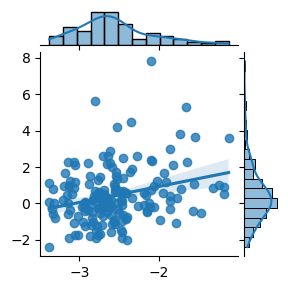

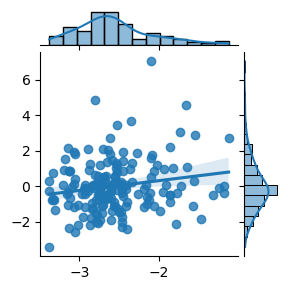

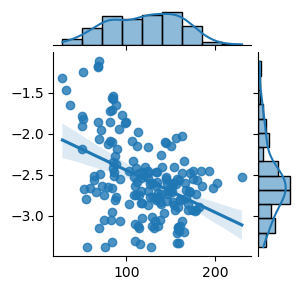

In [8]:
# Correlate functional connectivity with TMS-related power
import seaborn as sns
sns.jointplot(x=ephys_conn_clean_, y=Ts_, kind='reg', height=3)
plt.title('FC vs. raw T')
#plt.savefig('./multitaper_epo_plots/593_correlation.pdf')

from scipy.stats import pearsonr
print(pearsonr(ephys_conn_clean_, Ts_resid));

sns.jointplot(x=ephys_conn_clean_, y=Ts_resid, kind='reg', height=3)
plt.title('FC vs. resid T')
#plt.savefig('./multitaper_epo_plots/593_resid_fc_corr.pdf')

# Correlate functional connectivity with distance
from scipy.stats import boxcox
sns.jointplot(x=boxcox(dists_clean)[0], y=ephys_conn_clean_, kind='reg', height=3)
plt.title('Distance vs. FC')

### Analyze across subjects

In [7]:
from codebase import subject_tfr
from scipy.special import logit
from scipy.stats import pearsonr

# Load the data
source_data = './multitaper_power/multitaper_power_0.05_0.55_30-50Hz.pkl'
df = pd.read_pickle(source_data) 
corr_dict = {}
corr_resid_dict = {}

# Exclude bad electrodes
df = df[(df['saturated']==False) & (df['noisy']==False) & (df['Seizure_Exclude']!=1)  & (df['T']>-10)]

# Get all subjects
all_subjects = df['subject'].unique()

# Containers for responders vs. non-responders
responders = []
non_responders = []

# Loop through all subjects and process fMRI connectivity vs. T-stat correlations
for subject in all_subjects: 
    
    df_sub = df[df['subject']==subject]
    
    for target in df_sub['target'].unique():
        
        # Load the sham data for an example subject
        mytfr = subject_tfr()
        mytfr.load_data_epo(subject, target)
        df_sub_targ = copy(df_sub[df_sub['target']==target])  # Identify data for a specific TMS target
        
        try:
            target_contact = int(mytfr.epochs.metadata['target_contact'].iloc[0])
        except:
            continue

        # Compute spectral connectivity
        fc = mne_connectivity.spectral_connectivity_epochs(mytfr.epochs['sham'], method='coh', 
                                                           mode='multitaper', fmin=5, fmax=13, 
                                                          tmin=0.95, tmax=1.95, mt_bandwidth=4,
                                                          n_jobs=n_cpus, verbose=False)
        # Construct adjacency matrix
        adj = fc.get_data(output='dense')
        adj = np.mean(adj, 2)  # average over frequencies
        adj = adj+adj.T  # transpose and symmetrize
        
        # Add a column for connectivity values
        df_sub_targ['conn'] = ''
        df_sub_targ = df_sub_targ.reset_index() 

        # Identify stimulated contact (either known or grab nearest electrode to the stimulation coordinates)
        target_contact = int(mytfr.epochs.metadata['target_contact'].iloc[0])

        # Find vector of coherences from target contact
        node_names = pd.DataFrame(fc.names, columns=['name'])
        idxs = list(node_names[node_names['name'].str.contains('LFPx'+str(target_contact))].index)
        ephys_conn = logit(np.mean(adj[idxs, :], 0))  # average across all bipolar pairs containing the targeted contact
        dists = np.array(df_sub_targ['target_distance'])

        # Get TMS-related powers
        Ts = np.array(df_sub_targ['T'])

        # Some bad channels were statistically dropped from the powers array, so drop those from the
        # adjacency matrix, too
        ephys_conn_clean = []
        for idx, c in enumerate(df_sub_targ['channel_name']):
            ephys_idx = node_names[node_names['name']==c].index[0]
            ephys_conn_clean.append(ephys_conn[ephys_idx])
            df_sub_targ.loc[idx, 'conn'] = ephys_conn_clean[-1]
        ephys_conn_clean = np.array(ephys_conn_clean)

        # Finally, remove Infs or NaNs from both vectors
        Ts_ = Ts[(np.isfinite(Ts)) & (np.isfinite(ephys_conn_clean))]
        ephys_conn_clean_ = ephys_conn_clean[(np.isfinite(Ts)) & (np.isfinite(ephys_conn_clean))]
        dists_clean = dists[(np.isfinite(Ts)) & (np.isfinite(ephys_conn_clean))]
        
        # Compute Pearson correlation and save the data
        r, p = pearsonr(ephys_conn_clean_, Ts_)
        corr_dict[subject+'_'+target] = (r, p)
        
        # Average connectivity values for electrodes w/ significant response
        #responders.append(np.mean(df_sub_targ[(df_sub_targ['T']>2)]['conn']))
        #non_responders.append(np.mean(df_sub_targ[(df_sub_targ['T']<1) & (df_sub_targ['T']>-1)]['conn']))
        
        # Get the distance-predicted powers
        from sklearn.linear_model import LinearRegression
        model = LinearRegression()
        model.fit(dists_clean.reshape(-1, 1), Ts_)
        Ts_predict = model.predict(dists_clean.reshape(-1, 1))

        # Residualize the powers and rerun the correlation
        Ts_resid = Ts_-Ts_predict
        r, p = pearsonr(ephys_conn_clean_, Ts_resid)
        corr_resid_dict[subject+'_'+target] = (r, p)
        
        # Average connectivity values for electrodes w/ significant response
        responders.append(np.mean(ephys_conn_clean_[Ts_resid>2]))
        non_responders.append(np.mean(ephys_conn_clean_[(Ts_resid<1) & (Ts_resid>-1)]))
        
        # Save results
        #df_sub_targ.to_csv('D:/'+subject+'/5-13Hz_connectivity_'+subject+'_'+target+'_0.05_0.55_3-8Hz.csv')
        
responders, non_responders = np.array(responders), np.array(non_responders)

Reading D:\404\complete_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 11 columns
200 matching events found
No baseline correction applied
0 projection items activated
Reading D:\404\complete_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 11 columns
200 matching events found
No baseline correction applied
0 projection items activated
Reading D:\405\complete_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 11 columns
150 matching events found
No baseline correction applied
0 projection items activated
Reading D:\405\complete_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 11 co

Ttest_1sampResult(statistic=0.7184711509763685, pvalue=0.4874475347323928)


(array([1., 1., 5., 1., 0., 0., 1., 2., 0., 1.]),
 array([-2.56267128, -2.43705986, -2.31144845, -2.18583703, -2.06022561,
        -1.9346142 , -1.80900278, -1.68339137, -1.55777995, -1.43216853,
        -1.30655712]),
 <BarContainer object of 10 artists>)

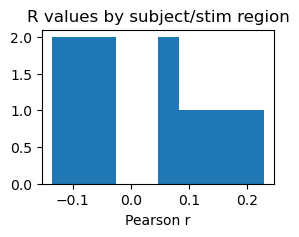

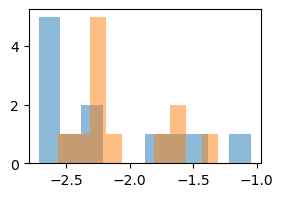

In [29]:
# Plot results
r_ = [a[0] for a in corr_resid_dict.values()]
plt.figure(figsize=(3, 2)); ax=plt.subplot(111)
plt.hist(r_, 10)
plt.title('R values by subject/stim region')
plt.xlabel('Pearson r')

from scipy.stats import ttest_1samp
print(ttest_1samp(r_, 0))

plt.figure(figsize=(3, 2)); ax=plt.subplot(111)
plt.hist(responders[np.isfinite(responders)], alpha=0.5); 
plt.hist(non_responders[np.isfinite(non_responders)], alpha=0.5)

Ttest_1sampResult(statistic=0.7184711509763685, pvalue=0.4874475347323928)


Ttest_indResult(statistic=-0.7373068841527033, pvalue=0.4687270407084867)

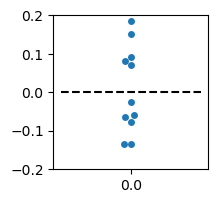

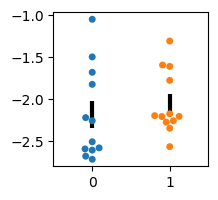

In [30]:
from scipy.stats import sem
from scipy.stats import ttest_rel

plt.figure(figsize=(2, 2)); ax=plt.subplot(111)
sns.swarmplot(x=np.zeros(len(r_)), y=r_)
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linestyle='--', color='k')
plt.ylim(-0.2, 0.2)
print(ttest_1samp(r_, 0))
plt.savefig('./multitaper_epo_plots/ephys_correlations_gamma_0-500ms.pdf')
#plt.savefig('./multitaper_epo_plots/eeg_conn_r.pdf')

plt.figure(figsize=(2, 2)); ax=plt.subplot(111)
toplot = [responders[np.isfinite(responders)], non_responders[np.isfinite(non_responders)]]
plt.errorbar(x=[0, 1], y=[np.mean(toplot[0]), np.mean(toplot[1])], yerr=[sem(toplot[0]), sem(toplot[1])], 
            linewidth=1, linestyle='None', capsize=0, ecolor='k', elinewidth=3,)
sns.swarmplot(data=toplot)
plt.savefig('./multitaper_epo_plots/eeg_responder_nonresponder_gamma_0-500ms.pdf')

from scipy.stats import ttest_ind
ttest_ind(responders[np.isfinite(responders)], non_responders[np.isfinite(non_responders)])  #ideally would use ttest_rel if data is available for all subjects

## Compare connectivity between target site and subcortical structures

In [63]:
from codebase import subject_tfr
from scipy.special import logit
from scipy.stats import pearsonr
from codebase import filter_dict

# Load the data
source_data = './multitaper_power/multitaper_power_0.05_0.55_30-50Hz.pkl'
df = pd.read_pickle(source_data) 
conn_df = pd.DataFrame()

# Exclude bad electrodes
df = df[(df['saturated']==False) & (df['noisy']==False) & (df['Seizure_Exclude']!=1)  & (df['T']>-10)]

# Get all subjects
all_subjects = df['subject'].unique()

# Containers for responders vs. non-responders
responders = []
non_responders = []

# Loop through all subjects and process fMRI connectivity vs. T-stat correlations
for subject in all_subjects[:]: 
    
    df_sub = df[df['subject']==subject]
    
    for target in df_sub['target'].unique()[:]:
        
        # Load the sham data for an example subject
        mytfr = subject_tfr()
        mytfr.load_data_epo(subject, target)
        df_sub_targ = copy(df_sub[df_sub['target']==target])  # Identify data for a specific TMS target
        
        try:
            target_contact = int(mytfr.epochs.metadata['target_contact'].iloc[0])
        except:
            continue

        # Compute spectral connectivity
        fc = mne_connectivity.spectral_connectivity_epochs(mytfr.epochs['sham'], method='coh', 
                                                           mode='multitaper', fmin=5, fmax=13, 
                                                          tmin=0.95, tmax=1.95, mt_bandwidth=4,
                                                          n_jobs=n_cpus, verbose=False)
        # Construct adjacency matrix
        adj = fc.get_data(output='dense')
        adj = np.mean(adj, 2)  # average over frequencies
        adj = adj+adj.T  # transpose and symmetrize
        
        # Add a column for connectivity values
        df_sub_targ['conn'] = ''
        df_sub_targ = df_sub_targ.reset_index() 

        # Identify stimulated contact (either known or grab nearest electrode to the stimulation coordinates)
        target_contact = int(mytfr.epochs.metadata['target_contact'].iloc[0])

        # Find vector of coherences from target contact
        node_names = pd.DataFrame(fc.names, columns=['name'])
        idxs = list(node_names[node_names['name'].str.contains('LFPx'+str(target_contact))].index)
        ephys_conn = logit(np.mean(adj[idxs, :], 0))  # average across all bipolar pairs containing the targeted contact
        dists = np.array(df_sub_targ['target_distance'])

        # Get TMS-related powers
        Ts = np.array(df_sub_targ['T'])

        # Some bad channels were statistically dropped from the powers array, so drop those from the
        # adjacency matrix, too
        ephys_conn_clean = []
        for idx, c in enumerate(df_sub_targ['channel_name']):
            ephys_idx = node_names[node_names['name']==c].index[0]
            ephys_conn_clean.append(ephys_conn[ephys_idx])
            df_sub_targ.loc[idx, 'conn'] = ephys_conn_clean[-1]
        ephys_conn_clean = np.array(ephys_conn_clean)
        
        # Update DataFrame with connectivity information
        conn_df = conn_df.append(df_sub_targ)
                                          

Reading D:\404\complete_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 11 columns
200 matching events found
No baseline correction applied
0 projection items activated
Reading D:\404\complete_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 11 columns
200 matching events found
No baseline correction applied
0 projection items activated
Reading D:\405\complete_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 11 columns
150 matching events found
No baseline correction applied
0 projection items activated
Reading D:\405\complete_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available


C:\Users\esolo\AppData\Local\Temp\ipykernel_29384\2567788576.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conn_df = conn_df.append(df_sub_targ)


Adding metadata with 11 columns
150 matching events found
No baseline correction applied
0 projection items activated
Reading D:\416\complete_epo.fif ...


C:\Users\esolo\AppData\Local\Temp\ipykernel_29384\2567788576.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conn_df = conn_df.append(df_sub_targ)


    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 11 columns
300 matching events found
No baseline correction applied
0 projection items activated
Reading D:\416\complete_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available


C:\Users\esolo\AppData\Local\Temp\ipykernel_29384\2567788576.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conn_df = conn_df.append(df_sub_targ)


Adding metadata with 11 columns
300 matching events found
No baseline correction applied
0 projection items activated
Reading D:\423\complete_epo.fif ...
    Found the data of interest:


C:\Users\esolo\AppData\Local\Temp\ipykernel_29384\2567788576.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conn_df = conn_df.append(df_sub_targ)


        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 11 columns
100 matching events found
No baseline correction applied
0 projection items activated
Reading D:\429\complete_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available


C:\Users\esolo\AppData\Local\Temp\ipykernel_29384\2567788576.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conn_df = conn_df.append(df_sub_targ)


Adding metadata with 11 columns
83 matching events found
No baseline correction applied
0 projection items activated
Reading D:\430\complete_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 11 columns
450 matching events found
No baseline correction applied
0 projection items activated
Reading D:\430\complete_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 11 columns
450 matching events found
No baseline correction applied
0 projection items activated
Reading D:\430\complete_epo.fif ...


C:\Users\esolo\AppData\Local\Temp\ipykernel_29384\2567788576.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conn_df = conn_df.append(df_sub_targ)


    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 11 columns
450 matching events found
No baseline correction applied
0 projection items activated
Reading D:\460\complete_epo.fif ...


C:\Users\esolo\AppData\Local\Temp\ipykernel_29384\2567788576.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conn_df = conn_df.append(df_sub_targ)


    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 11 columns
149 matching events found
No baseline correction applied
0 projection items activated
Reading D:\477\complete_epo.fif ...


C:\Users\esolo\AppData\Local\Temp\ipykernel_29384\2567788576.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conn_df = conn_df.append(df_sub_targ)


    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 11 columns
300 matching events found
No baseline correction applied
0 projection items activated
Reading D:\477\complete_epo.fif ...
    Found the data of interest:


C:\Users\esolo\AppData\Local\Temp\ipykernel_29384\2567788576.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conn_df = conn_df.append(df_sub_targ)


        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 11 columns
300 matching events found
No baseline correction applied
0 projection items activated
Reading D:\483\complete_epo.fif ...


C:\Users\esolo\AppData\Local\Temp\ipykernel_29384\2567788576.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conn_df = conn_df.append(df_sub_targ)


    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 11 columns
227 matching events found
No baseline correction applied
0 projection items activated
Reading D:\483\complete_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 11 columns
227 matching events found
No baseline correction applied
0 projection items activated
Reading D:\524\complete_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 11 columns
100 matching events found
No baseline correction applied
0 projection items activated
Reading D:\538\complete_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 11 columns
150 matching events found
No b

C:\Users\esolo\AppData\Local\Temp\ipykernel_29384\2567788576.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conn_df = conn_df.append(df_sub_targ)


Adding metadata with 11 columns
200 matching events found
No baseline correction applied
0 projection items activated
Reading D:\593\complete_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 11 columns
250 matching events found
No baseline correction applied
0 projection items activated


C:\Users\esolo\AppData\Local\Temp\ipykernel_29384\2567788576.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conn_df = conn_df.append(df_sub_targ)


Reading D:\634\complete_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 11 columns
500 matching events found
No baseline correction applied
0 projection items activated
Reading D:\634\complete_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 11 columns
500 matching events found
No baseline correction applied
0 projection items activated
Reading D:\634\complete_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 11 columns
500 matching events found
No baseline correction applied
0 projection items activated
Reading D:\634\complete_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 11 co

(array([1., 2., 0., 1., 1., 0., 0., 1., 1., 1.]),
 array([-2.84940441, -2.75077213, -2.65213986, -2.55350759, -2.45487532,
        -2.35624304, -2.25761077, -2.1589785 , -2.06034622, -1.96171395,
        -1.86308168]),
 <BarContainer object of 10 artists>)

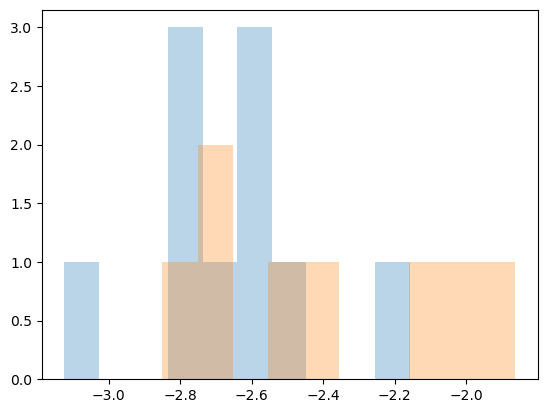

In [80]:
target = 'DLPFC'
record_1 = 'Amygdala'
record_2 = 'Hippocampus' #filter_dict['amygdala_filter']

plt.figure()
h = conn_df[conn_df['target'].str.contains(target) & conn_df['DKT_label'].str.contains(record_1)]['conn'].astype(float)
h = h[np.isfinite(h)]
plt.hist(h, alpha=0.3, label=record_1)

a = conn_df[conn_df['target'].str.contains(target) & conn_df['DKT_label'].str.contains(record_2)]['conn'].astype(float)
a = a[np.isfinite(a)]
plt.hist(a, alpha=0.3, label=record_2)
#plt.legend()

In [84]:
conn_df[conn_df['target'].str.contains(target) & conn_df['DKT_label'].str.contains(record_1)].groupby('subject').mean()

,index,MTL,T,pval,saturated,noisy,target_distance,target_x,target_y,target_z,Contact,Number,mniX,mniY,mniZ,anatX,anatY,anatZ,GM,Seizure_Exclude
subject,,,,,,,,,,,,,,,,,,,,
561,3098.000000,0.0,1.642812,0.103314,0.0,0.0,79.761429,-37.805290,28.95540,26.041450,189.000000,3.000000,25.735000,10.710000,-48.665000,25.742310,3.590155,-14.948700,1.000000,0.0
593,3364.111111,0.0,-1.095114,0.324566,0.0,0.0,73.922205,-25.312317,48.29801,40.000337,195.333333,4.444444,-10.266667,12.881111,-38.939444,-9.625528,8.950353,-16.468408,0.777778,0.0


In [85]:
conn_df[conn_df['target'].str.contains(target) & conn_df['DKT_label'].str.contains(record_2)].groupby('subject').mean()

,index,MTL,T,pval,saturated,noisy,target_distance,target_x,target_y,target_z,Contact,Number,mniX,mniY,mniZ,anatX,anatY,anatZ,GM,Seizure_Exclude
subject,,,,,,,,,,,,,,,,,,,,
460,1744.500000,1.0,-1.470387,0.152641,0.0,0.0,78.324023,-42.001000,35.20098,50.995010,85.500000,5.500000,-32.980000,-9.985000,-30.627500,-31.343550,-18.752120,-4.736065,1.0,0.0
477,2026.333333,1.0,1.540710,0.153672,0.0,0.0,71.358137,-41.999000,41.60299,38.995010,85.333333,2.333333,-29.871667,-12.598333,-30.270000,-31.051517,-9.083593,-9.362740,1.0,0.0
593,3376.666667,1.0,-0.705100,0.510904,0.0,0.0,78.246544,-25.312317,48.29801,40.000337,209.000000,3.000000,-10.820000,0.926667,-33.928333,-11.086850,-1.618660,-13.976363,1.0,0.0
